# QuTiPv5 Paper Example: Monte Carlo Solver for non-Markovian Baths

Authors: Maximilian Meyer-Mölleringhof (m.meyermoelleringhof@gmail.com), Paul Menczel (paul@menczel.net), Neill Lambert (nwlambert@gmail.com)

## Introduction

When a quantum system experiences non-Markovian effects, it can no longer be described by the standard Lindblad formalism.
To compute the time evolution of the density matrix, we can however use time-convolutionless (TCL) projection operators that lead to a differential equation in time-local form:

$\dot{\rho} (t) = - \dfrac{i}{\hbar} [H(t), \rho(t)] + \sum_n \gamma_n(t) \mathcal{D}_n(t) [\rho(t)]$

with

$\mathcal{D}_n[\rho(t)] = A_n \rho(t) A^\dagger_n - \dfrac{1}{2} [A^\dagger_n A_n \rho(t) + \rho(t) A_n^\dagger A_n]$.

These equations include the system Hamiltonian $H(t)$ and jump operators $A_n$.
Contrary to a Lindblad equation, the coupling rates $\gamma_n(t)$ may be negative here.

In QuTiP v5, the non-Markovian Monte Carlo solver is introduced.
It enables the mapping of the general master equation given above, to a Lindblad equation on the same Hilbert space.
This is achieved by the introduction of the so called "influence martingale" which acts as trajectory weighting [\[1, 2, 3\]](#References):

$\mu (t) = \exp \left[ \alpha \int_0^t s(\tau) d \tau \right] \Pi_k \dfrac{\gamma_{n_k} (t_k)}{\Gamma_{n_k} (t_k)}$.

Here, the product runs over all jump operators on the trajectory with jump channels $n_k$ and jump times $t_k < t$.
To finally arrive at the Lindblad form, the shift function

$s(t) = 2 \left| \min \{ 0, \gamma_1(t), \gamma_2(t), ... \} \right|$

is applied, such that the shifted rates $\Gamma_n (t) = \gamma_n(t) + s(t)$ are non-negative.
We obtain the completely positive Lindblad equation

$\dot{\rho}'(t) = - \dfrac{i}{\hbar} [ H(t), \rho'(t) ] + \sum_n \Gamma(t) \mathcal{D}_n[\rho'(t)]$,

and $\rho'(t) = \mathbb{E} \{\ket{\psi(t)} \bra{\psi(t)}\}$ using the regular MCWF method.
Here, $\ket{\psi (t)}$ are the generated trajectories and $\mathbb{E}$ is the ensemble average over the trajectories.
This can furthermore be used to finally reconstruct the original states via $\rho(t) = \mathbb{E}\{\mu(t) \ket{\psi(t)} \bra{\psi(t)}\}$.

Note that, for this technique, the jump operators are required to fulfill the completeness relation $\sum_n A_n^\dagger A_n = \alpha \mathbb{1}$ for $\alpha > 0$.
This condition is automatically taken care of by QuTiP's `nm_mcsolve()` function.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (ExponentialBosonicEnvironment, about, basis, brmesolve,
                   expect, heom, ket2dm, lindblad_dissipator, liouvillian,
                   mesolve, nm_mcsolve, qeye, sigmam, sigmap, sigmax, sigmay,
                   sigmaz)
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar

## Damped Jaynes-Cumming Model

To illustrate the application of `nm_mcsolve()`, we want to look at the damped Jaynes-Cumming model.
It describes a two-level atom coupled to a damped cavity mode.
Such a model can be accurately model as a two-level system coupled to an environment with the power spectrum [\[4\]](#References):

$S(\omega) = \dfrac{\lambda \Gamma^2}{(\omega_0 - \Delta - \omega)^2 + \Gamma^2}$,

where $\lambda$ is the atom-cavity coupling strength, $\omega_0$ is the transition frequency of the atom, $\Delta$ the detuning of the cavity and $\Gamma$ the spectral width.
At zero temperature and after performing the rotating wave approximation, the dynamics of the two-level atom can be described by the master equation

$\dot{\rho}(t) = \dfrac{A(t)}{2i\hbar} [ \sigma_+ \sigma_-, \rho(t) ] + \gamma (t) \mathcal{D}_- [\rho (t)]$,

with the state $\rho(t)$ in the interaction picture, the the ladder operators $\sigma_\pm$, the dissipator $\mathcal{D}_-$ for the Lindblad operator $\sigma_-$, and lastly $\gamma (t)$ and $A(t)$ being the real and imaginary parts of

$\gamma(t) + i A(t) = \dfrac{2 \lambda \Gamma \sinh (\delta t / 2)}{\delta \cosh (\delta t / 2) + (\Gamma - i \Delta) \sinh (\delta t/2)}$,

with $\delta = [(\Gamma - i \Delta)^2 - 2 \lambda \Gamma]^{1/2}$.

In [2]:
H = sigmap() * sigmam() / 2
initial_state = (basis(2, 0) + basis(2, 1)).unit()
tlist = np.linspace(0, 5, 500)

In [3]:
# Constants
gamma0 = 1
lamb = 0.3 * gamma0
Delta = 8 * lamb

# Derived Quantities
delta = np.sqrt((lamb - 1j * Delta) ** 2 - 2 * gamma0 * lamb)
deltaR = np.real(delta)
deltaI = np.imag(delta)
deltaSq = deltaR**2 + deltaI**2

In [4]:
# calculate gamma and A
def prefac(t):
    return (
        2
        * gamma0
        * lamb
        / (
            (lamb**2 + Delta**2 - deltaSq) * np.cos(deltaI * t)
            - (lamb**2 + Delta**2 + deltaSq) * np.cosh(deltaR * t)
            - 2 * (Delta * deltaR + lamb * deltaI) * np.sin(deltaI * t)
            + 2 * (Delta * deltaI - lamb * deltaR) * np.sinh(deltaR * t)
        )
    )


def cgamma(t):
    return prefac(t) * (
        lamb * np.cos(deltaI * t)
        - lamb * np.cosh(deltaR * t)
        - deltaI * np.sin(deltaI * t)
        - deltaR * np.sinh(deltaR * t)
    )


def cA(t):
    return prefac(t) * (
        Delta * np.cos(deltaI * t)
        - Delta * np.cosh(deltaR * t)
        - deltaR * np.sin(deltaI * t)
        + deltaI * np.sinh(deltaR * t)
    )

In [5]:
_gamma = np.zeros_like(tlist)
_A = np.zeros_like(tlist)
for i in range(len(tlist)):
    _gamma[i] = cgamma(tlist[i])
    _A[i] = cA(tlist[i])

gamma = CubicSpline(tlist, np.complex128(_gamma))
A = CubicSpline(tlist, np.complex128(_A))

In [6]:
unitary_gen = liouvillian(H)
dissipator = lindblad_dissipator(sigmam())

In [7]:
mc_sol = nm_mcsolve(
    [[H, A]],
    initial_state,
    tlist,
    ops_and_rates=[(sigmam(), gamma)],
    ntraj=1_000,
    options={"map": "parallel"},
    seeds=0,
)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/data/expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


10.0%. Run time:   1.58s. Est. time left: 00:00:00:14


20.0%. Run time:   3.10s. Est. time left: 00:00:00:12


30.0%. Run time:   4.57s. Est. time left: 00:00:00:10


40.0%. Run time:   6.14s. Est. time left: 00:00:00:09


50.0%. Run time:   7.62s. Est. time left: 00:00:00:07


60.0%. Run time:   9.14s. Est. time left: 00:00:00:06


70.0%. Run time:  10.70s. Est. time left: 00:00:00:04


80.0%. Run time:  12.19s. Est. time left: 00:00:00:03


90.0%. Run time:  13.73s. Est. time left: 00:00:00:01


100.0%. Run time:  15.22s. Est. time left: 00:00:00:00


Total run time:  15.24s


## Comparison to other methods

We want to compare this computation with the standard `mesolve()`, the HEOM and the Bloch-Refield solver.
For the `mesolve()` we can directly use the operators we have created for `nm_mcsolve()`:

In [8]:
me_sol = mesolve([[unitary_gen, A], [dissipator, gamma]], initial_state, tlist)

For the other methods we directly apply a spin-boson model and the free reservoir auto-correlation function

$C(t) = \dfrac{\lambda \Gamma}{2} e^{-i (\omega - \Delta) t - \lambda |t|}$,

which corresponds to the power spectrum defined above.
We use the Hamiltonian $H = \omega_0 \sigma_+ \sigma_-$ in the Schrödinger picture and the coupling operator $Q = \sigma_+ + \sigma_-$.
Here, we chose $\omega_0 \gg \Delta$ to ensure validity of the rotating wave approximation.

In [9]:
omega_c = 100
omega_0 = omega_c + Delta

H = omega_0 * sigmap() * sigmam()
Q = sigmap() + sigmam()


def power_spectrum(w):
    return gamma0 * lamb**2 / ((omega_c - w) ** 2 + lamb**2)

Firstly, the HEOM solver can directly be applied after separating the auto-correlation function into its real and imaginary parts:

In [10]:
ck_real = [gamma0 * lamb / 4] * 2
vk_real = [lamb - 1j * omega_c, lamb + 1j * omega_c]
ck_imag = np.array([1j, -1j]) * gamma0 * lamb / 4
vk_imag = vk_real

In [11]:
heom_env = ExponentialBosonicEnvironment(ck_real, vk_real, ck_imag, vk_imag)
heom_sol = heom.heomsolve(H, (heom_env, Q), 10, ket2dm(initial_state), tlist)

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00


20.0%. Run time:   0.05s. Est. time left: 00:00:00:00


30.1%. Run time:   0.08s. Est. time left: 00:00:00:00


40.1%. Run time:   0.10s. Est. time left: 00:00:00:00


50.1%. Run time:   0.13s. Est. time left: 00:00:00:00


60.1%. Run time:   0.16s. Est. time left: 00:00:00:00


70.1%. Run time:   0.18s. Est. time left: 00:00:00:00


80.2%. Run time:   0.21s. Est. time left: 00:00:00:00


90.2%. Run time:   0.23s. Est. time left: 00:00:00:00


100.0%. Run time:   0.26s. Est. time left: 00:00:00:00


Total run time:   0.26s


Secondly, for the Bloch-Redfield solver we can directly use the power spectrum as input:

In [12]:
br_sol = brmesolve(H, initial_state, tlist, a_ops=[(sigmax(), power_spectrum)])

Finally, in order to compare these results with the `nm_mesolve()` method, we transform them to the interaction picture:

In [13]:
Us = [(-1j * H * t).expm() for t in tlist]
heom_states = [U * s * U.dag() for (U, s) in zip(Us, heom_sol.states)]
br_states = [U * s * U.dag() for (U, s) in zip(Us, br_sol.states)]

### Plotting the Time Evolution

We choose to plot three comparisons to highlight the different solvers' computational results.
In all plots, the gray areas show when $\gamma(t)$ is negative.

In [14]:
root1 = root_scalar(lambda t: cgamma(t), method="bisect", bracket=(1, 2)).root
root2 = root_scalar(lambda t: cgamma(t), method="bisect", bracket=(2, 3)).root
root3 = root_scalar(lambda t: cgamma(t), method="bisect", bracket=(3, 4)).root
root4 = root_scalar(lambda t: cgamma(t), method="bisect", bracket=(4, 5)).root

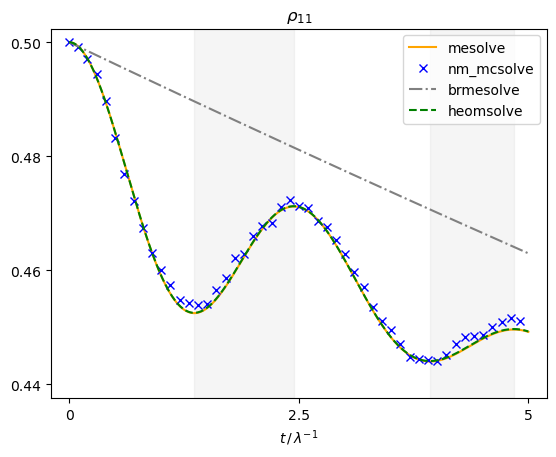

In [15]:
projector = (sigmaz() + qeye(2)) / 2

rho11_me = expect(projector, me_sol.states)
rho11_mc = expect(projector, mc_sol.states)
rho11_br = expect(projector, br_sol.states)
rho11_heom = expect(projector, heom_states)

plt.plot(tlist, rho11_me, "-", color="orange", label="mesolve")
plt.plot(
    tlist[::10],
    rho11_mc[::10],
    "x",
    color="blue",
    label="nm_mcsolve",
)
plt.plot(tlist, rho11_br, "-.", color="gray", label="brmesolve")
plt.plot(tlist, rho11_heom, "--", color="green", label="heomsolve")

plt.xlabel(r"$t\, /\, \lambda^{-1}$")
plt.xlim((-0.2, 5.2))
plt.xticks([0, 2.5, 5], labels=["0", "2.5", "5"])
plt.title(r"$\rho_{11}$")
plt.ylim((0.4376, 0.5024))
plt.yticks([0.44, 0.46, 0.48, 0.5], labels=["0.44", "0.46", "0.48", "0.50"])

plt.axvspan(root1, root2, color="gray", alpha=0.08, zorder=0)
plt.axvspan(root3, root4, color="gray", alpha=0.08, zorder=0)

plt.legend()
plt.show()

In [16]:
me_x = expect(sigmax(), me_sol.states)
mc_x = expect(sigmax(), mc_sol.states)
heom_x = expect(sigmax(), heom_states)
br_x = expect(sigmax(), br_states)

me_y = expect(sigmay(), me_sol.states)
mc_y = expect(sigmay(), mc_sol.states)
heom_y = expect(sigmay(), heom_states)
br_y = expect(sigmay(), br_states)

In [17]:
# We smooth the HEOM result because it oscillates quickly and gets hard to see
rho01_heom = heom_x * heom_x + heom_y * heom_y
rho01_heom = np.convolve(rho01_heom, np.array([1 / 11] * 11), mode="valid")
heom_tlist = tlist[5:-5]

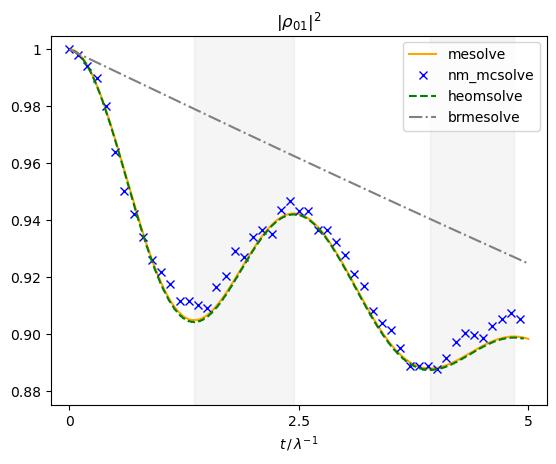

In [18]:
rho01_me = me_x * me_x + me_y * me_y
rho01_mc = mc_x * mc_x + mc_y * mc_y
rho01_br = br_x * br_x + br_y * br_y

plt.plot(tlist, rho01_me, "-", color="orange", label=r"mesolve")
plt.plot(tlist[::10], rho01_mc[::10], "x", color="blue", label=r"nm_mcsolve")
plt.plot(heom_tlist, rho01_heom, "--", color="green", label=r"heomsolve")
plt.plot(tlist, rho01_br, "-.", color="gray", label=r"brmesolve")

plt.xlabel(r"$t\, /\, \lambda^{-1}$")
plt.xlim((-0.2, 5.2))
plt.xticks([0, 2.5, 5], labels=["0", "2.5", "5"])
plt.title(r"$| \rho_{01} |^2$")
plt.ylim((0.8752, 1.0048))
plt.yticks(
    [0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1],
    labels=["0.88", "0.90", "0.92", "0.94", "0.96", "0.98", "1"],
)

plt.axvspan(root1, root2, color="gray", alpha=0.08, zorder=0)
plt.axvspan(root3, root4, color="gray", alpha=0.08, zorder=0)

plt.legend()
plt.show()

In [19]:
mart_dev = mc_sol.trace - 1

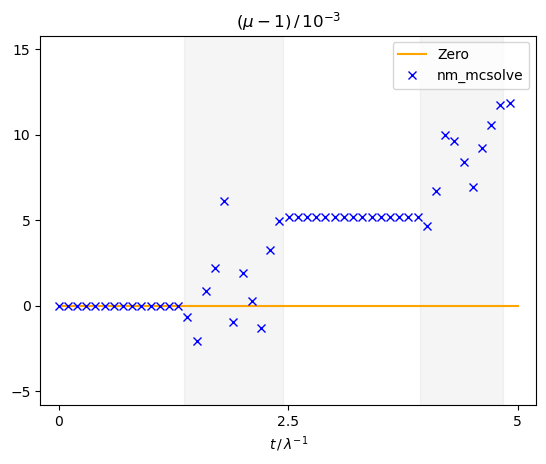

In [20]:
plt.plot(tlist, np.zeros_like(tlist), "-", color="orange", label=r"Zero")
plt.plot(
    tlist[::10],
    1000 * mart_dev[::10],
    "x",
    color="blue",
    label=r"nm_mcsolve",
)

plt.xlabel(r"$t\, /\, \lambda^{-1}$")
plt.xlim((-0.2, 5.2))
plt.xticks([0, 2.5, 5], labels=["0", "2.5", "5"])
plt.title(r"$(\mu - 1)\, /\, 10^{-3}$")
plt.ylim((-5.8, 15.8))
plt.yticks([-5, 0, 5, 10, 15])

plt.axvspan(root1, root2, color="gray", alpha=0.08, zorder=0)
plt.axvspan(root3, root4, color="gray", alpha=0.08, zorder=0)

plt.legend()
plt.show()

In these plots we notice two things.
First, the result from the Bloch-Redfield equation deviates greatly from the others, showing us that non-Markovian effects are strongly influencing the dynamics.
Second, in the grey areas - when $\gamma(t)$ is negative - the atom state restores coherence.
In the last plot especially we see that during these times, the average influence martingale fluctuates, but is constant otherwise.
Its deviation from unity tells us how well the simulation has converged.


## References

\[1\] [Donvil and Muratore-Ginanneschi. Nat Commun (2022).](https://www.nature.com/articles/s41467-022-31533-8)

\[2\] [Donvil and Muratore-Ginanneschi. New J. Phys. (2023).](https://dx.doi.org/10.1088/1367-2630/acd4dc)

\[3\] [Donvil and Muratore-Ginanneschi. *Open Systems & Information Dynamics*.](https://www.worldscientific.com/worldscinet/osid)

\[4\] [Breuer and Petruccione *The Theory of Open Quantum Systems*.](https://doi.org/10.1093/acprof:oso/9780199213900.001.0001)

\[5\] [QuTiP 5: The Quantum Toolbox in Python](https://arxiv.org/abs/2412.04705)


## About

In [21]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

In [22]:
assert np.allclose(
    rho11_me, rho11_heom, atol=1e-3
), "rho11 of mesolve and heomsolve do not agree."
assert np.allclose(
    rho11_me, rho11_mc, atol=1e-2
), "rho11 of nm_mcsolve deviates from mesolve too much."
assert np.allclose(
    rho01_me[5:-5], rho01_heom, atol=1e-3
), "|rho01|^2 of mesolve and heomsolve do not agree."
assert np.allclose(
    rho01_me, rho01_mc, atol=1e-1
), "|rho01|^2 of nm_mcsolve deviates from mesolve too much."
assert (
    np.max(mart_dev) < 1e-1
), "MC Simulation has not converged well enough. Average infl. mart. > 1e-1"